# Text Classification

In this notebook, we will introduce a text classification project, the main task is a topic prediction for a text(question or statement etc.).<br>
The labels include 16 classes, which is described in data/label.csv<br>
The datasets include train(129176) and test(32614), you can see in the dir(data)<br>
We will use a small dataset to  set the example.<br>

We will use some traditional statistical features like TDIDF..<br>
Model type : xgboost/RandomForest<br>
Function : feature extractor / model training / params selection / data balance etc..

In [2]:
import pandas as pd 
import numpy as np

In [3]:
train = pd.read_csv("./data/train.csv",names=["id","Discuss","label"],dtype={"Discuss":str})
test = pd.read_csv("./data/test.csv",names=["id","Discuss"],dtype={"Discuss":str})
print(len(train),len(test))
# drop null values
train.dropna(inplace=True)
test.dropna(inplace=True)
print(len(train),len(test))
train['length']= train.Discuss.apply(lambda x:len(x))
test['length']= test.Discuss.apply(lambda x:len(x))
# use small datasets
train=train[:10000]
test=test[:10000]
train_y = train.label.values

129176 32614
129169 32610


In [7]:
train.label.value_counts()

0     1351
3      852
2      845
1      739
4      728
5      703
9      613
6      547
7      505
13     488
14     475
8      455
15     451
11     436
12     421
10     391
Name: label, dtype: int64

<strong>Dataset Sample</strong><br>
columns : id,text,label<br>

2600784210,如何 最快 确定 自己 乘坐 的 飞机 自 几号 航站楼 起飞,0 <br>
1813305872,为什么 知乎 的 用户 看起来 更 喜欢 咖啡馆 而不是 茶馆,0 <br>

We can see, the text are splited as a word unit in advance.<br>
In this notebook, we will use 'char' feature instead of word, you can try it.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csr_matrix,hstack

tfidf=TfidfVectorizer(analyzer='char',ngram_range=(1,1)) # char 
tfidf
# tfidf=TfidfVectorizer(analyzer='word',ngram_range=(1,1),token_pattern='(?u)\\b[^ ]+\\b')
# cv = CountVectorizer(ngram_range=(1,1),min_df=1,token_pattern='(?u)\\b[^ ]+\\b') # ngram=1 same as tfidf
# ha = HashingVectorizer(ngram_range=(1,1),token_pattern='(?u)\\b[^ ]+\\b')

TfidfVectorizer(analyzer='char')

In [5]:
train_x_tfidf = tfidf.fit_transform(train.Discuss)
test_x_tfidf = tfidf.fit_transform(test.Discuss)
# train_x_ha = ha.fit_transform(train.Discuss)
# test_x_ha = ha.fit_transform(test.Discuss)
# train_x_cv = cv.fit_transform(train.Discuss)
# test_x_cv = cv.fit_transform(test.Discuss)
mm=MinMaxScaler()
train_len=mm.fit_transform(train.length.values.reshape(-1,1))
test_len=mm.fit_transform(test.length.values.reshape(-1,1))
del mm
print(train_x_tfidf.shape,test_x_tfidf.shape,train_len.shape,test_len.shape)

(10000, 3115) (10000, 3129) (10000, 1) (10000, 1)


In [6]:
#you can see the the tfidf word vocabulary size
print(len(tfidf.vocabulary_))

3129


concat all the features in same dimension <br>
split dataset in train/val<br>

In [7]:
train_x =np.hstack((train_x_tfidf.toarray(),csr_matrix(train_len).toarray()))
print(train_x.shape)
test_x =np.hstack((test_x_tfidf.toarray(),csr_matrix(test_len).toarray()))
print(test_x.shape)

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(train_x,train_y,test_size=0.3,random_state=0)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(10000, 3116)
(10000, 3130)
(7000, 3116) (3000, 3116) (7000,) (3000,)


# XGBClassifier

define the model training and evaluation processdure.<br>
you use the inline function, like CV(cross validation) to choose the best params; <br>use xgb.plot_importance to figure out the most important feature.<br> use grid search to find a beet params

In [8]:

import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.metrics import log_loss
from matplotlib import pyplot as plt
# from matplotlib.pylab import rcParams
%matplotlib inline

def modelfit(alg,X_train,Y_train,X_test=None,Y_test=None,useTrainCV=True,cv_folds=3,early_stopping_rounds=50,verbose=10):
    if useTrainCV:
        print("CV cross validation start .......")
        xgb_param = alg.get_xgb_params()
        xgbtrain=xgb.DMatrix(X_train,label = Y_train)
        cvresult = xgb.cv(xgb_param,xgbtrain,num_boost_round=alg.get_params()['n_estimators'],nfold=cv_folds,
                         metrics = xgb_param['eval_metric'],early_stopping_rounds=early_stopping_rounds,verbose_eval = verbose)
        n_estimators = cvresult.shape[0]
        print('Best number of trees = {}'.format(cvresult.shape[0]))
        alg.set_params(n_estimators = n_estimators) 
    print('Fit on the training data')
    alg.fit(X_train,Y_train)
    
    #predicting on training set
    #if objective set as softmax, output is class（onehot）；
    #if objective set as softprob, output is probability
    train_prob = alg.predict_proba(X_train)
    #caculating loss
    logloss = log_loss(Y_train,train_prob)
    print ("loss = ",logloss)
    train_pred = np.argmax(np.array(train_prob),axis=1)
    print("train acc = %f"%metrics.accuracy_score(Y_train,train_pred))
    
    if X_test is not None and Y_test is not None:
        test_pred = alg.predict(X_test)
        print("test_acc: %f"% metrics.accuracy_score(Y_test,test_pred))
    
    #show the importance of features
    ax=plt.subplot()
    xgb.plot_importance(alg,ax=ax,height=0.5,importance_type='weight',max_num_features=20,grid=True)
    plt.gcf().set_size_inches(10,8)
    plt.gcf().set_tight_layout(True)
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("Score",fontsize=20)
    plt.ylabel("FeatureName",fontsize=20)
    plt.title("Feature importance",fontsize=25)

CV cross validation start .......
[0]	train-mlogloss:2.55545+0.00224	test-mlogloss:2.59659+0.00320
[10]	train-mlogloss:1.70555+0.00613	test-mlogloss:2.02834+0.00221
[20]	train-mlogloss:1.33821+0.00533	test-mlogloss:1.85296+0.00527
[30]	train-mlogloss:1.10876+0.00548	test-mlogloss:1.77220+0.00883
[40]	train-mlogloss:0.94793+0.00543	test-mlogloss:1.72950+0.00884
[50]	train-mlogloss:0.83001+0.00709	test-mlogloss:1.70602+0.01013
[60]	train-mlogloss:0.73513+0.00818	test-mlogloss:1.69201+0.00954
[70]	train-mlogloss:0.65783+0.00687	test-mlogloss:1.68323+0.01034
[80]	train-mlogloss:0.59414+0.00641	test-mlogloss:1.67855+0.01083
[90]	train-mlogloss:0.53860+0.00701	test-mlogloss:1.67563+0.01203
[99]	train-mlogloss:0.49492+0.00717	test-mlogloss:1.67353+0.01270
最好的树的个数　： 100
训练得到了最优树，采用分类和回归模型  学习和预测.
loss =  0.6033842182538606
train acc = 0.913571
test_acc: 0.521333


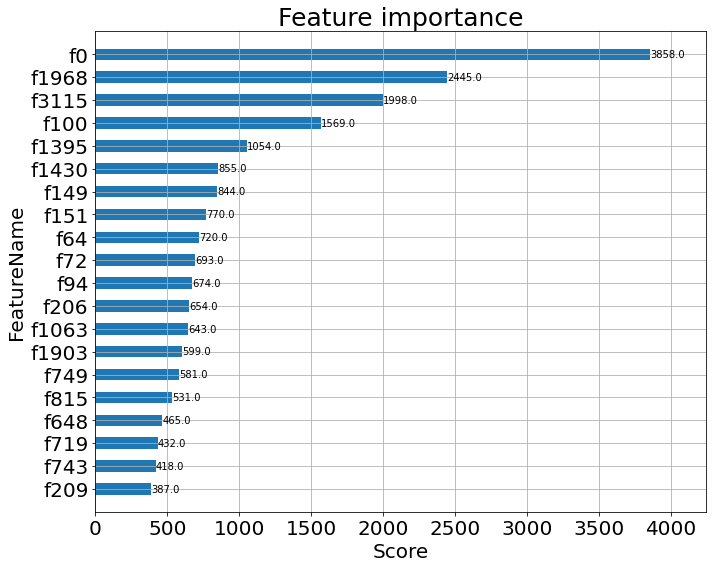

In [9]:
xgb_classfier = XGBClassifier(
        booster='gbtree',
     learning_rate =0.1,
     n_estimators=100,
     max_depth=8,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'multi:softprob',
     nthread=6,
     num_class=16,
     eval_metric='mlogloss',
     seed=27)


modelfit(xgb_classfier, x_train,y_train,x_test,y_test)

find best params use gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [22]:
param_test1={'gamma':[i/10.0 for i in range(0,5)]}
param_test2 = {
 'max_depth': [4,5,6,7],
 'min_child_weight':[5,6,7,8]
}
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
xgb_classfier_1 = XGBClassifier(
        booster='gbtree',
     learning_rate =0.1,
     n_estimators=10, # need set 
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'multi:softprob',
     nthread=7,
     num_class=16,
     eval_metric='mlogloss',
     seed=27)

#采用网格搜索得到最优参数
kfold = list(StratifiedKFold(n_splits=2,random_state=2018,shuffle=True).split(x_train,y_train))
gsearch_1 = GridSearchCV(xgb_classfier_1,param_grid=param_test1,scoring='neg_log_loss',n_jobs=6,cv=kfold,verbose=True)
gsearch_1.fit(x_train,y_train)


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:  2.1min finished


GridSearchCV(cv=[(array([   0,    2,    3, ..., 6995, 6998, 6999]),
                  array([   1,    5,    6, ..., 6992, 6996, 6997])),
                 (array([   1,    5,    6, ..., 6992, 6996, 6997]),
                  array([   0,    2,    3, ..., 6995, 6998, 6999]))],
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     ev...
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
    

In [25]:
print(gsearch_1.best_params_)
print(gsearch_1.best_score_)

{'gamma': 0.3}
-2.092239456815379


Fit on the trainingsdata
loss =  0.9911033956532234
train acc = 0.753143
test_acc: 0.501333


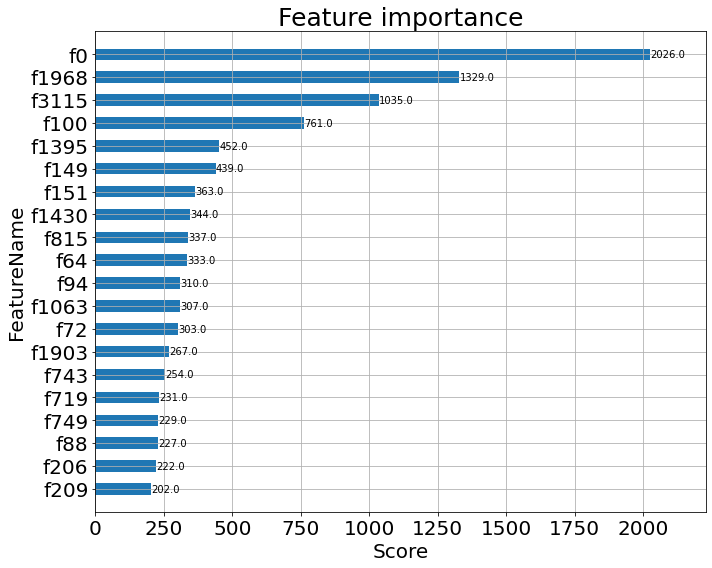

In [32]:
#set the best params, then fit the model
xgb_classfier_1_best = XGBClassifier(
        booster='gbtree',
     learning_rate =0.1,
     n_estimators=100,
     max_depth=7,
     min_child_weight=5,
     gamma=0.3, # the best param: 0.3
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'multi:softprob',
     nthread=6,
     num_class=16,
     eval_metric='mlogloss',
     seed=27)
modelfit(xgb_classfier_1_best, x_train,y_train,x_test,y_test,False)

# RandomForestClassifier

In [24]:
import sklearn
import numpy as np
from collections import Counter
from sklearn import ensemble
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold#分层抽样

def training(X_train,Y_train,X_test,Y_test,nfold):
    folds = list(StratifiedKFold(n_splits=nfold,random_state=2018,shuffle=True).split(X_train,Y_train))
    
    model = ensemble.RandomForestClassifier(n_estimators=200)
    for j, (train_fold,val_fold) in enumerate(folds):
        print(u"start {}/{} training.".format(j+1,nfold))
        x_train,x_val,y_train,y_val=X_train[train_fold,:],X_train[val_fold,:],Y_train[train_fold],Y_train[val_fold]
        model.fit(x_train,y_train)
        
        val_ = model.predict(X=x_val)
        pred_ = model.predict(X=X_test)
        
        val_acc = sklearn.metrics.accuracy_score(y_val,val_)
        print(u"cross validation {} result :{}".format(j+1, val_acc))
        test_acc = sklearn.metrics.accuracy_score(Y_test,pred_)
        print(u"test result :{}".format(test_acc))
    
        
training(x_train,y_train,x_test,y_test,5)


start 1/5 training.
cross validation 1 result :0.49214285714285716
test result :0.49133333333333334
start 2/5 training.
cross validation 2 result :0.49142857142857144
test result :0.49133333333333334
start 3/5 training.
cross validation 3 result :0.46785714285714286
test result :0.492
start 4/5 training.
cross validation 4 result :0.5
test result :0.495
start 5/5 training.
cross validation 5 result :0.5057142857142857
test result :0.49433333333333335


# Dataset Balance

use the imblearn lib to solve the problem

In [7]:
from imblearn.over_sampling import SMOTE,ADASYN
from collections import Counter
# before the operation
print(sorted(Counter(train.label).items()))
X_resampled,y_resampled = SMOTE().fit_sample(train_x,train.label)
# after the operation
print(sorted(Counter(y_resampled).items()))

[(0, 1351), (1, 739), (2, 845), (3, 852), (4, 728), (5, 703), (6, 547), (7, 505), (8, 455), (9, 613), (10, 391), (11, 436), (12, 421), (13, 488), (14, 475), (15, 451)]
[(0, 1351), (1, 1351), (2, 1351), (3, 1351), (4, 1351), (5, 1351), (6, 1351), (7, 1351), (8, 1351), (9, 1351), (10, 1351), (11, 1351), (12, 1351), (13, 1351), (14, 1351), (15, 1351)]
